In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Load dataset and preprocess
pivot_df = pd.read_csv("synthetic_temp_polling_data.csv")
#pivot_df = pd.read_csv("synthetic_temp_polling_data_reversed.csv")
#pivot_df = pd.read_csv("synthetic_scenario_30_nodes.csv")
pivot_df = pivot_df.apply(lambda x: x.fillna(x.mean()), axis=0)  # Fill missing values
pivot_df = pivot_df.head(10000)  # Restrict to first 20000 time steps

# Parameters
reward = 0.5
M = 1 # Number of nodes to poll at each time step
theta = 0.0  # Threshold for node transmission
penalty = -0.5  # Penalty when the condition is not met
num_nodes = 30  # Total number of nodes in the dataset

# Extract column names, ensuring "SN" is excluded
columns = [col for col in pivot_df.columns if col != "SN"]

# Track the number of times each category is polled
category_counts = {'Category A': 0, 'Category B': 0}

# Initialize state vectors and covariance matrices
x_hat_node = {col: np.array([20.0, 0.1]) for col in columns}
P_node = {col: np.eye(2) for col in columns}
x_hat_sink = {col: np.array([20.0, 0.1]) for col in columns}

# Track last update times
last_update_times = {col: 0 for col in columns}

# Kalman filter matrices
A_node = np.array([[1, 1],  # State transition matrix
                   [0, 1]])
Q_node = np.array([[0.01, 0],  # Process noise covariance
                   [0, 0.01]])
H_node = np.array([[1, 0]])  # Observation matrix
R = np.array([[0.1]])  # Measurement noise covariance

# Function to extract numeric node ID from column names dynamically
def extract_node_id(col_name):
    """Extract numeric node ID from column name, handling cases where no digits are found."""
    digits = ''.join(filter(str.isdigit, col_name))
    return int(digits) if digits else None  # Return None if no digits are found

# Kalman filter function for nodes
def kalman_node(measured_value, x_hat, P):
    xp = A_node @ x_hat
    Pp = A_node @ P @ A_node.T + Q_node
    K = Pp @ H_node.T @ np.linalg.inv(H_node @ Pp @ H_node.T + R)
    x_hat = xp + K @ (measured_value - H_node @ xp)
    P = Pp - K @ H_node @ Pp
    return x_hat, P

# Predict node state from sink
def predict_node_state_from_sink(x_hat, delta_t_dynamic):
    predicted_value = x_hat[0] + x_hat[1] * delta_t_dynamic
    return np.array([predicted_value, x_hat[1]])

# Polling function with transmission count tracking
def poll_nodes(pivot_df, current_time, x_hat_node, x_hat_sink, P_node, M):
    exceedance_values = {}

    # Step 1: Predict sink values and check if threshold is exceeded
    for column_name in columns:
        last_update_time = last_update_times[column_name]
        delta_t_dynamic = current_time + 1 - last_update_time

        predicted_value = predict_node_state_from_sink(x_hat_sink[column_name], delta_t_dynamic)[0]
        if abs(predicted_value - x_hat_sink[column_name][0]) > theta:
            exceedance_values[column_name] = abs(predicted_value - x_hat_sink[column_name][0])

    # Step 2: Select top M nodes
    nodes_to_poll = sorted(exceedance_values, key=exceedance_values.get, reverse=True)[:M]

    # Step 3: Poll selected nodes
    for column_name in nodes_to_poll:
        measured_value = pivot_df.loc[current_time, column_name]

        # Node Kalman filtering
        x_hat_node[column_name], P_node[column_name] = kalman_node(measured_value, x_hat_node[column_name], P_node[column_name])
        x_hat_sink[column_name] = x_hat_node[column_name]  # Update sink state

        last_update_times[column_name] = current_time



        # Extract node ID dynamically and categorize
        node_id = extract_node_id(column_name)
        if node_id is not None:
            if 1 <= node_id <= 5:
                category_counts['Category A'] += 1
            elif 6 <= node_id <= 10:
                category_counts['Category B'] += 1
           

    return x_hat_node, x_hat_sink, P_node



# Simulation settings
num_steps = len(pivot_df)

# Run the simulation
for t in range(num_steps):
    x_hat_node, x_hat_sink, P_node= poll_nodes(
        pivot_df, t, x_hat_node, x_hat_sink, P_node, M
    )
    
# Print the number of times each category was pulled
print("Transmission Count by Category:")
for category, count in category_counts.items():
    print(f"{category}: {count} times")





Transmission Count by Category:
Category A: 9430 times
Category B: 570 times


In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Load dataset and preprocess
pivot_df = pd.read_csv("synthetic_temp_polling_data.csv")
#pivot_df = pd.read_csv("synthetic_scenario_30_nodes.csv")
pivot_df = pivot_df.apply(lambda x: x.fillna(x.mean()), axis=0)  # Fill missing values
pivot_df = pivot_df.head(10000)  # Restrict to first 20000 time steps

# Parameters
reward = 0.5
M = 1  # Number of nodes to poll at each time step
theta = 0.0  # Threshold for node transmission
penalty = -0.5  # Penalty when the condition is not met
num_nodes = 30  # Total number of nodes in the dataset

# Extract column names, ensuring "SN" is excluded
columns = [col for col in pivot_df.columns if col != "SN"]

# Track the number of times each category is polled
category_counts = {'Category A': 0, 'Category B': 0, 'Category C': 0}

# Initialize state vectors and covariance matrices
x_hat_node = {col: np.array([20.0, 0.1]) for col in columns}
P_node = {col: np.eye(2) for col in columns}
x_hat_sink = {col: np.array([20.0, 0.1]) for col in columns}

# Initialize dictionaries to store predictions and true values for MSE calculation
predictions = {col: [] for col in columns}
true_values = {col: [] for col in columns}

# Track last update times
last_update_times = {col: 0 for col in columns}

# Kalman filter matrices
A_node = np.array([[1, 1],  # State transition matrix
                   [0, 1]])
Q_node = np.array([[0.01, 0],  # Process noise covariance
                   [0, 0.01]])
H_node = np.array([[1, 0]])  # Observation matrix
R = np.array([[0.1]])  # Measurement noise covariance

# Function to extract numeric node ID from column names dynamically
def extract_node_id(col_name):
    """Extract numeric node ID from column name, handling cases where no digits are found."""
    digits = ''.join(filter(str.isdigit, col_name))
    return int(digits) if digits else None  # Return None if no digits are found

# Function to get node category
def get_node_category(node_id):
    if node_id is None:
        return None
    if 1 <= node_id <= 5:
        return 'Category A'
    elif 6 <= node_id <= 10:
        return 'Category B'
    elif 21 <= node_id <= 30:
        return 'Category C'
    else:
        return None

# Kalman filter function for nodes
def kalman_node(measured_value, x_hat, P):
    xp = A_node @ x_hat
    Pp = A_node @ P @ A_node.T + Q_node
    K = Pp @ H_node.T @ np.linalg.inv(H_node @ Pp @ H_node.T + R)
    x_hat = xp + K @ (measured_value - H_node @ xp)
    P = Pp - K @ H_node @ Pp
    return x_hat, P

# Predict node state from sink
def predict_node_state_from_sink(x_hat, delta_t_dynamic):
    predicted_value = x_hat[0] + x_hat[1] * delta_t_dynamic
    return np.array([predicted_value, x_hat[1]])

# Polling function with transmission count tracking
def poll_nodes(pivot_df, current_time, x_hat_node, x_hat_sink, P_node, M):
    exceedance_values = {}

    # Step 1: Predict sink values and check if threshold is exceeded
    for column_name in columns:
        last_update_time = last_update_times[column_name]
        delta_t_dynamic = current_time + 1 - last_update_time

        predicted_state = predict_node_state_from_sink(x_hat_sink[column_name], delta_t_dynamic)
        predicted_value = predicted_state[0]
        
        # Store prediction and true value for MSE calculation
        predictions[column_name].append(predicted_value)
        true_values[column_name].append(pivot_df.loc[current_time, column_name])
        
        if abs(predicted_value - x_hat_sink[column_name][0]) > theta:
            exceedance_values[column_name] = abs(predicted_value - x_hat_sink[column_name][0])

    # Step 2: Select top M nodes
    nodes_to_poll = sorted(exceedance_values, key=exceedance_values.get, reverse=True)[:M]

    # Step 3: Poll selected nodes
    for column_name in nodes_to_poll:
        measured_value = pivot_df.loc[current_time, column_name]

        # Node Kalman filtering
        x_hat_node[column_name], P_node[column_name] = kalman_node(measured_value, x_hat_node[column_name], P_node[column_name])
        x_hat_sink[column_name] = x_hat_node[column_name]  # Update sink state

        last_update_times[column_name] = current_time

        # Extract node ID dynamically and categorize
        node_id = extract_node_id(column_name)
        if node_id is not None:
            if 1 <= node_id <= 5:
                category_counts['Category A'] += 1
            elif 6 <= node_id <= 10:
                category_counts['Category B'] += 1
            elif 21 <= node_id <= 30:
                category_counts['Category C'] += 1

    return x_hat_node, x_hat_sink, P_node



# Simulation settings
num_steps = len(pivot_df)

# Run the simulation
for t in range(num_steps):
    x_hat_node, x_hat_sink, P_node = poll_nodes(
        pivot_df, t, x_hat_node, x_hat_sink, P_node, M
    )
    
# Print the number of times each category was pulled
print("Transmission Count by Category:")
for category, count in category_counts.items():
    print(f"{category}: {count} times")

# Calculate MSE for each node
node_mse = {}
for column_name in columns:
    node_mse[column_name] = mean_squared_error(true_values[column_name], predictions[column_name])

# Calculate total MSE
all_true_values = []
all_predictions = []
for column_name in columns:
    all_true_values.extend(true_values[column_name])
    all_predictions.extend(predictions[column_name])

total_mse = mean_squared_error(all_true_values, all_predictions)
print(f"\nTotal MSE: {total_mse:.4f}")

# Calculate MSE per category
category_mse = {'Category A': [], 'Category B': [], 'Category C': []}
for column_name in columns:
    node_id = extract_node_id(column_name)
    category = get_node_category(node_id)
    if category:
        category_mse[category].append(node_mse[column_name])

# Print MSE per category
print("\nMSE by Category:")
for category, mse_values in category_mse.items():
    if mse_values:
        avg_mse = np.mean(mse_values)
        print(f"{category}: {avg_mse:.4f}")

# Optional: Create a bar chart of MSE by category
categories = list(category_mse.keys())
avg_mse_values = [np.mean(mse_values) if mse_values else 0 for mse_values in category_mse.values()]



Transmission Count by Category:
Category A: 9430 times
Category B: 570 times
Category C: 0 times

Total MSE: 4.3623

MSE by Category:
Category A: 8.5985
Category B: 0.1261


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

# Load dataset and preprocess
pivot_df = pd.read_csv("synthetic_temp_polling_data.csv")
pivot_df = pivot_df.apply(lambda x: x.fillna(x.mean()), axis=0)  # Fill missing values
pivot_df = pivot_df.head(10000)  # Restrict to first 20000 time steps

# Parameters
M = 2  # Number of nodes to poll at each time step
num_nodes = 30  # Total number of nodes in the dataset

# Extract column names, ensuring "SN" is excluded
columns = [col for col in pivot_df.columns if col != "SN"]

# Track the number of times each category is polled
category_counts = {'Category A': 0, 'Category B': 0, 'Category C': 0}

# Initialize state and covariance matrices - temperature only
x_hat_node = {col: 20.0 for col in columns}  # Single value for temperature
P_node = {col: 1.0 for col in columns}  # Single value for covariance
x_hat_sink = {col: 20.0 for col in columns}  # Single value for temperature at sink

# Initialize dictionaries to store predictions and true values for MSE calculation
true_values = {col: [] for col in columns}
estimates = {col: [] for col in columns}  # Store the current estimate for each node

# Track last update times
last_update_times = {col: 0 for col in columns}

# Kalman filter matrices - simplified for scalar case
A = 1.0  # State transition (identity for constant model)
Q = 0.001  # Process noise variance
H = 1.0  # Observation matrix
R = 0.01  # Measurement noise variance

# Function to extract numeric node ID from column names
def extract_node_id(col_name):
    """Extract numeric node ID from column name, handling cases where no digits are found."""
    digits = ''.join(filter(str.isdigit, col_name))
    return int(digits) if digits else None  # Return None if no digits are found

# Function to get node category
def get_node_category(node_id):
    if node_id is None:
        return None
    if 1 <= node_id <= 5:
        return 'Category A'
    elif 6 <= node_id <= 10:
        return 'Category B'
    elif 21 <= node_id <= 30:
        return 'Category C'
    else:
        return None

# Simplified Kalman filter for scalar case
def kalman_scalar(measured_value, x_hat, P):
    # Prediction step
    x_pred = A * x_hat
    P_pred = A * P * A + Q
    
    # Update step
    K = P_pred * H / (H * P_pred * H + R)
    x_new = x_pred + K * (measured_value - H * x_pred)
    P_new = (1 - K * H) * P_pred
    
    return x_new, P_new

# Polling function
def poll_nodes(pivot_df, current_time, x_hat_node, x_hat_sink, P_node, M):
    # Store the true values for all nodes at this time step
    for column_name in columns:
        true_values[column_name].append(pivot_df.loc[current_time, column_name])
        estimates[column_name].append(x_hat_sink[column_name])  # Current estimate
    
    # For this simplified version, we'll just poll random nodes
    # This could be modified to use any selection strategy
    nodes_to_poll = np.random.choice(columns, size=min(M, len(columns)), replace=False)
    
    # Poll selected nodes
    for column_name in nodes_to_poll:
        measured_value = pivot_df.loc[current_time, column_name]

        # Node Kalman filtering (scalar case)
        x_hat_node[column_name], P_node[column_name] = kalman_scalar(
            measured_value, x_hat_node[column_name], P_node[column_name]
        )
        
        # Update sink state
        x_hat_sink[column_name] = x_hat_node[column_name]
        last_update_times[column_name] = current_time

        # Track polling by category
        node_id = extract_node_id(column_name)
        if node_id is not None:
            if 1 <= node_id <= 5:
                category_counts['Category A'] += 1
            elif 6 <= node_id <= 10:
                category_counts['Category B'] += 1
            elif 21 <= node_id <= 30:
                category_counts['Category C'] += 1

    return x_hat_node, x_hat_sink, P_node

# Simulation settings
num_steps = len(pivot_df)

# Run the simulation
for t in range(num_steps):
    x_hat_node, x_hat_sink, P_node = poll_nodes(
        pivot_df, t, x_hat_node, x_hat_sink, P_node, M
    )
    
# Print the number of times each category was pulled
print("Transmission Count by Category:")
for category, count in category_counts.items():
    print(f"{category}: {count} times")

# Calculate MSE for each node
node_mse = {}
for column_name in columns:
    node_mse[column_name] = mean_squared_error(true_values[column_name], estimates[column_name])

# Calculate total MSE
all_true_values = []
all_estimates = []
for column_name in columns:
    all_true_values.extend(true_values[column_name])
    all_estimates.extend(estimates[column_name])

total_mse = mean_squared_error(all_true_values, all_estimates)
print(f"\nTotal MSE: {total_mse:.4f}")

# Calculate MSE per category
category_mse = {'Category A': [], 'Category B': [], 'Category C': []}
for column_name in columns:
    node_id = extract_node_id(column_name)
    category = get_node_category(node_id)
    if category:
        category_mse[category].append(node_mse[column_name])

# Print MSE per category
print("\nMSE by Category:")
for category, mse_values in category_mse.items():
    if mse_values:
        avg_mse = np.mean(mse_values)
        print(f"{category}: {avg_mse:.4f}")

Transmission Count by Category:
Category A: 20080 times
Category B: 19920 times
Category C: 0 times

Total MSE: 0.0265

MSE by Category:
Category A: 0.0501
Category B: 0.0029


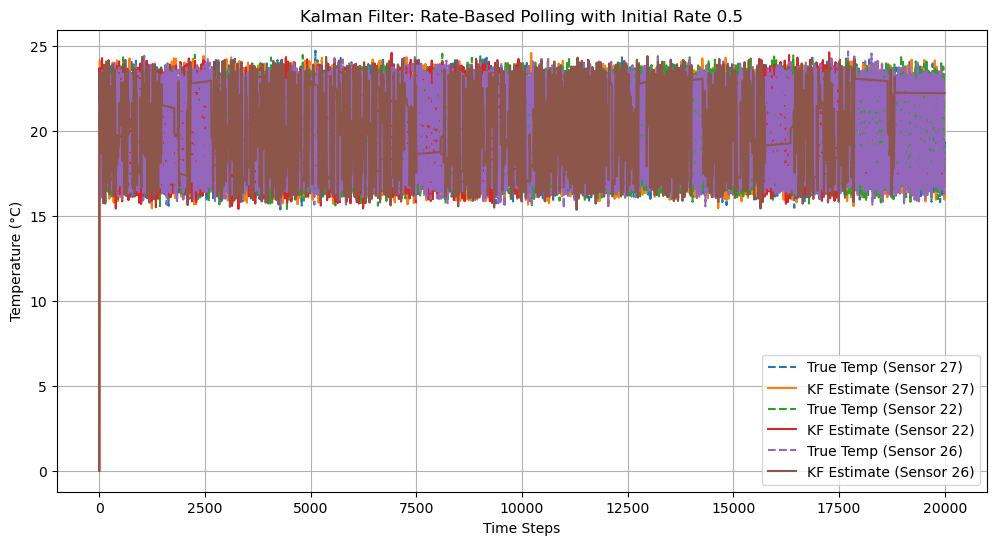


Final Average MSE: 5.957947

Final counts of how many times each category was polled:
{'Category A': 4119, 'Category B': 4673, 'Category C': 48961}

Sensors polled at last time step: [14  9 12 24 30]


In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Load dataset and preprocess
pivot_df = pd.read_csv("synthetic_scenario_30_nodes.csv")
pivot_df = pivot_df.apply(lambda x: x.fillna(x.mean()), axis=0)  # Fill missing values
pivot_df = pivot_df.head(20000)  # Restrict to first 20000 time steps

# Define parameters
num_sensors = pivot_df.shape[1]  # Number of sensors
time_steps = pivot_df.shape[0]  # Number of time steps
M = 5  # Number of sensors to poll at each time step
initial_rate = 0.5  # Initial rate of change to ensure early polling

# Kalman Filter Parameters
dt = 1  # Time step
A = np.array([[1, dt], [0, 1]])  # State transition matrix
H = np.array([[1, 0]])  # Observation matrix (we only measure temperature)
Q = np.array([[1e-3, 0], [0, 1e-3]])  # Process noise covariance
R = np.array([[0.5]])  # Measurement noise covariance

# Initialize Kalman Filter states (temperature & rate of change)
X = np.zeros((num_sensors, 2, 1))  # Initial state for each sensor
X[:, 0, 0] = pivot_df.iloc[0, :].values  # Initialize temperature estimates
X[:, 1, 0] = initial_rate  # Initialize rate of change with nonzero value

# Initial estimate uncertainty (P matrix)
P = np.array([np.eye(2) for _ in range(num_sensors)])  # Covariance per sensor

# Initialize last update times for all sensors
last_update_times = np.zeros(num_sensors)

# Initialize category count tracker
category_counts = {'Category A': 0, 'Category B': 0, 'Category C': 0}

# Function to extract node ID from column name
def extract_node_id(column_name):
    try:
        return int(''.join(filter(str.isdigit, column_name)))  # Extract numeric part
    except ValueError:
        return None  # In case of invalid format

# Store estimated temperatures & MSE tracking
estimated_temperatures = np.zeros((time_steps, num_sensors))
mse_list = []

# Kalman filter loop
for t in range(1, time_steps):
    # Step 1: Prediction (for all sensors)
    for i in range(num_sensors):
        X[i] = A @ X[i]  # Predict next state
        P[i] = A @ P[i] @ A.T + Q  # Predict next covariance

    # Step 2: Compute polling scores based on rate of change * time elapsed
    polling_scores = np.array([(t - last_update_times[i]) * abs(X[i, 1, 0]) for i in range(num_sensors)])
    polled_indices = np.argsort(polling_scores)[-M:]  # Select M nodes with highest score

    # Step 3: Update step (only for polled sensors)
    for i in polled_indices:
        Z = np.array([[pivot_df.iloc[t, i]]])  # Measurement for this sensor
        y = Z - (H @ X[i])  # Measurement residual
        S = H @ P[i] @ H.T + R  # Residual covariance
        K = P[i] @ H.T @ np.linalg.inv(S)  # Kalman Gain
        X[i] = X[i] + K @ y  # Update estimate
        P[i] = (np.eye(2) - K @ H) @ P[i]  # Update covariance
        last_update_times[i] = t  # Reset last update time for this node

        # Step 4: Categorize polled sensors
        node_id = extract_node_id(pivot_df.columns[i])
        if node_id is not None:
            if 1 <= node_id <= 5:
                category_counts['Category A'] += 1
            elif 6 <= node_id <= 10:
                category_counts['Category B'] += 1
            elif 21 <= node_id <= 30:
                category_counts['Category C'] += 1

    # Store estimates
    estimated_temperatures[t, :] = X[:, 0, 0]

    # Compute MSE for this time step
    mse_list.append(mean_squared_error(pivot_df.iloc[t, :], estimated_temperatures[t, :]))

# Compute final average MSE
average_mse = np.mean(mse_list)

# Plot results for a few random sensors
plt.figure(figsize=(12, 6))
for i in np.random.choice(num_sensors, 3, replace=False):  # Plot 3 random sensors
    plt.plot(pivot_df.iloc[:, i], label=f"True Temp (Sensor {i})", linestyle="dashed")
    plt.plot(estimated_temperatures[:, i], label=f"KF Estimate (Sensor {i})")

plt.xlabel("Time Steps")
plt.ylabel("Temperature (°C)")
plt.title("Kalman Filter: Rate-Based Polling with Initial Rate 0.5")
plt.legend()
plt.grid()
plt.show()

# Display final MSE and category polling counts
print(f"\nFinal Average MSE: {average_mse:.6f}")
print(f"\nFinal counts of how many times each category was polled:")
print(category_counts)
print(f"\nSensors polled at last time step: {polled_indices}")

